<a href="https://colab.research.google.com/github/FernandoBRdgz/inteligencia_artificial/blob/main/redes_generativas_adversarias/gan_convolucional_profunda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from IPython import display

In [2]:
!nvidia-smi

Wed May 10 18:43:14 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
def plot_results(images, n_cols=None, epoch=0):
    display.clear_output(wait=False)

    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1

    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    
    fig = plt.figure(figsize=(n_cols, n_rows))
    fig.suptitle(f"Epochs {epoch}", fontsize="x-large")

    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")
    
    plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))

In [4]:
(X_train, _), _  = tf.keras.datasets.fashion_mnist.load_data()
X_train = X_train.astype(np.float32) / 255
X_train = X_train.reshape(-1, 28, 28, 1) * 2 - 1.

BATCH_SIZE = 128

dataset = tf.data.Dataset.from_tensor_slices(X_train)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=False).prefetch(1)

4422102/4422102 [==============================] - 0s 0us/step


In [5]:
codings_size = 32

generator = tf.keras.models.Sequential()
generator.add(tf.keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]))
generator.add(tf.keras.layers.Reshape([7, 7, 128]))
generator.add(tf.keras.layers.BatchNormalization())
generator.add(tf.keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME", activation="selu"))
generator.add(tf.keras.layers.BatchNormalization())
generator.add(tf.keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME", activation="tanh"))

generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 6272)              206976    
                                                                 
 reshape (Reshape)           (None, 7, 7, 128)         0         
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 128)        512       
 ormalization)                                                   
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       204864    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       256       
 hNormalization)                                                 
                                                        

Shape of the generated batch: (16, 28, 28, 1)


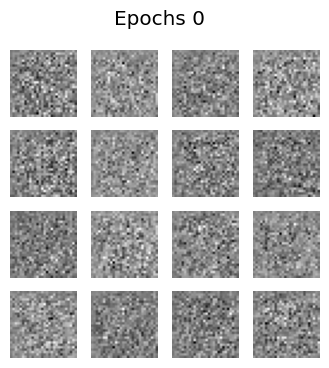

In [6]:
test_noise = tf.random.normal([16, codings_size])
test_image = generator(test_noise)
plot_results(test_image, n_cols=4, epoch=0)

print(f"Shape of the generated batch: {test_image.shape}")

In [7]:
discriminator = tf.keras.models.Sequential()
discriminator.add(tf.keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME", activation=tf.keras.layers.LeakyReLU(0.2), input_shape=[28, 28, 1]))
discriminator.add(tf.keras.layers.Dropout(0.4))
discriminator.add(tf.keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME", activation=tf.keras.layers.LeakyReLU(0.2)))
discriminator.add(tf.keras.layers.Dropout(0.4))
discriminator.add(tf.keras.layers.Flatten())
discriminator.add(tf.keras.layers.Dense(1, activation="sigmoid"))

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6273      
                                                                 
Total params: 212,865
Trainable params: 212,865
Non-tr

In [8]:
gan = tf.keras.models.Sequential([generator, discriminator])

In [9]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [10]:
def train_gan(gan, dataset, random_normal_dimensions, n_epochs=50):
    generator, discriminator = gan.layers

    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))       

        for real_images in dataset:
            batch_size = real_images.shape[0]
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])
            fake_images = generator(noise)
            mixed_images = tf.concat([fake_images, real_images], axis=0)
            discriminator_labels = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            discriminator.trainable = True
            discriminator.train_on_batch(mixed_images, discriminator_labels)

            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])
            generator_labels = tf.constant([[1.]] * batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, generator_labels)

        plot_results(fake_images, 16, epoch)                     
        plt.show()  

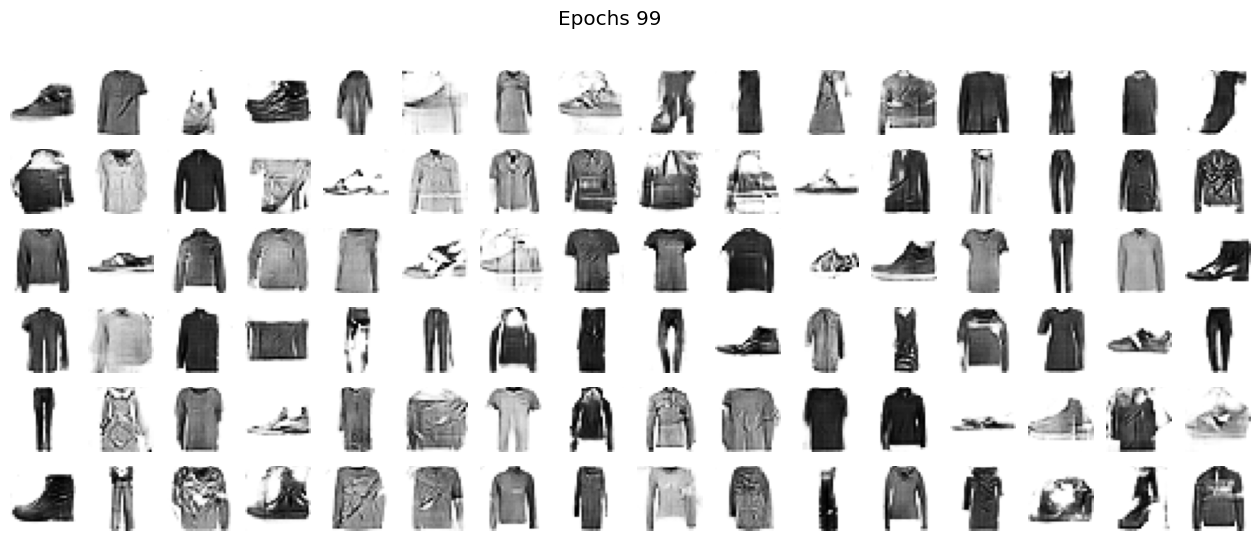

CPU times: user 33min 28s, sys: 1min 12s, total: 34min 40s
Wall time: 34min 49s


In [11]:
%%time
train_gan(gan, dataset, codings_size, 100)

**Por hacer**

* Añadir descripción y objetivos
* Añadir referencias
* Añadir comentarios